# [Code Generation with AlphaCodium: From Prompt Engineering to Flow Engineering](https://arxiv.org/pdf/2401.08500.pdf)

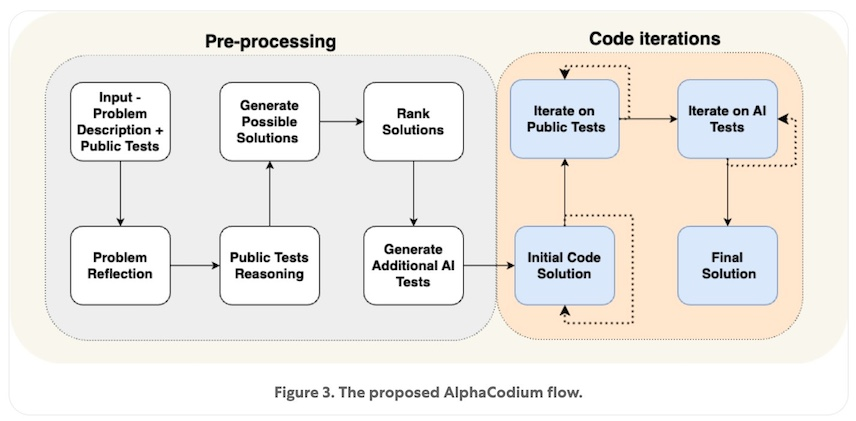

# Code generation with flow



AlphaCodium presented an approach for code generation that uses control flow.

Main idea: [construct an answer to a coding question iteratively.](https://x.com/karpathy/status/1748043513156272416?s=20). 

[AlphaCodium](https://github.com/Codium-ai/AlphaCodium) iteravely tests and improves an answer on public and AI-generated tests for a particular question. 

We will implement some of these ideas from scratch using [LangGraph](https://python.langchain.com/docs/langgraph):

1. We start with a set of documentation specified by a user
2. We use a long context LLM to ingest it, and answer a question based upon it 
3. We perform two unit tests: Check imports and code execution

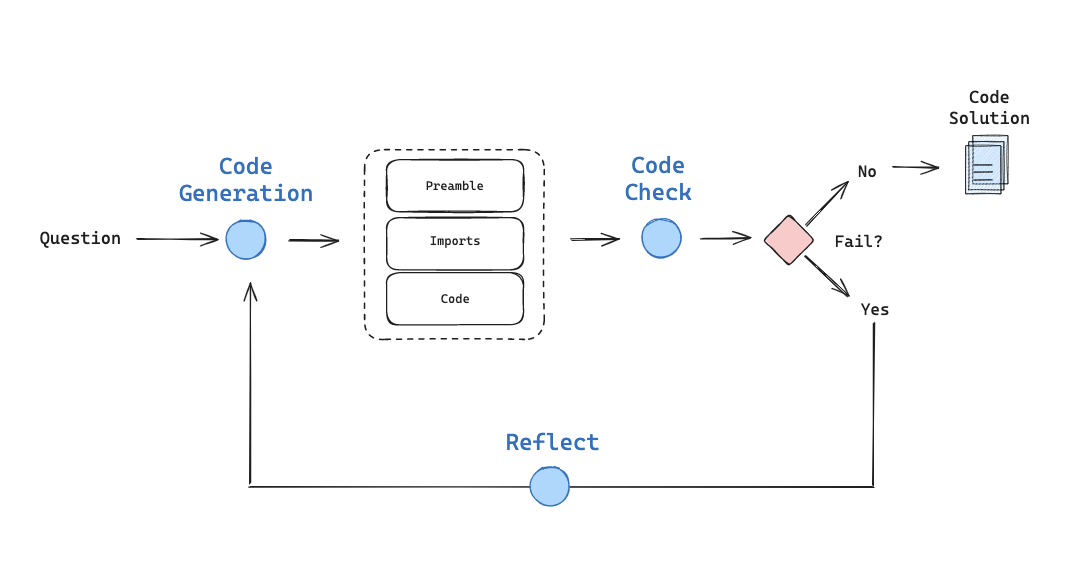

In [2]:
 ! pip install -qU langchain_community langchain-openai langchain-anthropic langchain langgraph bs4

## Docs

Load [LangChain Expression Language](https://python.langchain.com/docs/expression_language/) (LCEL) docs as an example.

In [3]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

## LLMs

### Code solution

Try OpenAI and [Claude3](https://docs.anthropic.com/claude/docs/models-overview) with function calling.

In [5]:
import os
import getpass
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API key:")

OpenAI API key: ········


**OpenAI**

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

### OpenAI

# Grader prompt 
code_gen_prompt = ChatPromptTemplate.from_messages(
    [("system","""You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is a full set of LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user 
    question based on the above provided documentation. Ensure any code you provide can be executed \n 
    with all required imports and variables defined. Structure your answer with a description of the code solution. \n
    Then list the imports. And finally list the functioning code block. Here is the user question:"""),
    ("placeholder", "{messages}")]
)

# Data model
class code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
    description = "Schema for code solutions to questions about LCEL."

expt_llm = "gpt-4-0125-preview"
llm = ChatOpenAI(temperature=0, model=expt_llm)
code_gen_chain = code_gen_prompt | llm.with_structured_output(code)
question = "How do I build a RAG chain in LCEL?"
# solution = code_gen_chain_oai.invoke({"context":concatenated_content,"messages":[("user",question)]})

/Users/jackiexc/GitHub/LLM_Cookbooks/venv/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `with_structured_output` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


**Anthropic**

In [3]:
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

### Anthropic

# Prompt to enforce tool use
code_gen_prompt_claude = ChatPromptTemplate.from_messages(
    [("system","""<instructions> You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is the LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user  question based on the \n 
    above provided documentation. Ensure any code you provide can be executed with all required imports and variables \n
    defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block. \n
    Invoke the code tool to structure the output correctly. </instructions> \n Here is the user question:""",),
    ("placeholder", "{messages}"),])

# Data model
class code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
    description = "Schema for code solutions to questions about LCEL."


# LLM
# expt_llm = "claude-3-haiku-20240307" 
expt_llm = "claude-3-opus-20240229"  
llm = ChatAnthropic(
    model=expt_llm,
    default_headers={"anthropic-beta": "tools-2024-04-04"},
)

structured_llm_claude = llm.with_structured_output(code, include_raw=True)

# Optional: Check for errors in case tool use is flaky
def check_claude_output(tool_output):
    """Check for parse error or failure to call the tool"""

    # Error with parsing
    if tool_output["parsing_error"]:
        # Report back output and parsing errors
        print("Parsing error!")
        raw_output = str(code_output["raw"].content)
        error = tool_output["parsing_error"]
        raise ValueError(
            f"Error parsing your output! Be sure to invoke the tool. Output: {raw_output}. \n Parse error: {error}"
        )

    # Tool was not invoked 
    elif not tool_output["parsed"]:
        print("Failed to invoke tool!")
        raise ValueError(
            f"You did not use the provided tool! Be sure to invoke the tool to structure the output."
        )
    return tool_output

# Chain with output check
code_chain_claude_raw = code_gen_prompt_claude | structured_llm_claude | check_claude_output

def insert_errors(inputs):
    """Insert errors for tool parsing in the messages"""
    
    # Get errors
    error = inputs["error"]
    messages = inputs["messages"]
    messages += [
        (
            "assistant",
            f"Retry. You are required to fix the parsing errors: {error} \n\n You must invoke the provided tool.",
        )
    ]
    return {
        "messages": messages,
        "context": inputs["context"],
    }

# This will be run as a fallback chain
fallback_chain = insert_errors | code_chain_claude_raw
N = 3  # Max re-tries
code_gen_chain_re_try = code_chain_claude_raw.with_fallbacks(fallbacks=[fallback_chain] * N, exception_key="error")

def parse_output(solution):
    """When we add 'include_raw=True' to structured output, 
       it will return a dict w 'raw', 'parsed', 'parsing_error'. """
    
    return solution['parsed']

# Wtih re-try to correct for failure to invoke tool
# TODO: Annoying errors w/ "user" vs "assistant" 
# Roles must alternate between "user" and "assistant", but found multiple "user" roles in a row
code_gen_chain = code_gen_chain_re_try | parse_output

# No re-try
code_gen_chain = code_gen_prompt_claude | structured_llm_claude | parse_output

In [7]:
# Test
question = "How do I build a RAG chain in LCEL?"
solution = code_gen_chain.invoke({"context":concatenated_content,"messages":[("user",question)]})
solution

code(prefix="To build a Retrieval-Augmented Generation (RAG) chain in LCEL, you'll need to combine several components: a retriever to fetch relevant documents based on the input query, a prompt template to format the retrieved documents and the query for the language model, and finally, a language model to generate the response based on the formatted prompt. Here's how you can do it:", imports='from langchain_core.prompts import ChatPromptTemplate\nfrom langchain_core.runnables import RunnableParallel, RunnablePassthrough\nfrom langchain_openai import ChatOpenAI, OpenAIEmbeddings\nfrom langchain_community.vectorstores import DocArrayInMemorySearch\nfrom langchain_core.output_parsers import StrOutputParser', code='# Initialize the components\nvectorstore = DocArrayInMemorySearch.from_texts(\n    ["harrison worked at kensho", "bears like to eat honey"],\n    embedding=OpenAIEmbeddings(),\n)\nretriever = vectorstore.as_retriever()\n\nprompt_template = ChatPromptTemplate.from_template(\n  

## State 

Our state is a dict that will contain keys (errors, question, code generation) relevant to code generation.

In [9]:
from typing import Dict, TypedDict, List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries 
    """

    error : str
    messages : List
    generation : str
    iterations : int

## Graph 

Our graph lays out the logical flow shown in the figure above.

In [10]:
from operator import itemgetter
from langchain.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough

### Parameter

# Max tries
max_iterations = 3
# Reflect
# flag = 'reflect'
flag = 'do not reflect'
 
### Nodes

def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")
    
    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [("user","Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:")]
        
    # Solution
    code_solution = code_gen_chain.invoke({"context": concatenated_content, "messages" : messages})
    messages += [("assistant",f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}")]
    
    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}

def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")
    
    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    prefix = code_solution.prefix
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {"generation": code_solution, "messages": messages, "iterations": iterations, "error": "yes"}
    
    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {"generation": code_solution, "messages": messages, "iterations": iterations, "error": "yes"}
  
    # No errors
    print("---NO CODE TEST FAILURES---")
    return {"generation": code_solution, "messages": messages, "iterations": iterations, "error": "no"}

def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")
    
    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection
    reflection_message = [("user", """You tried to solve this problem and failed a unit test. Reflect on this failure
                                    given the provided documentation. Write a few key suggestions based on the 
                                    documentation to avoid making this mistake again.""")]
    
    # Add reflection
    reflections = code_gen_chain.invoke({"context"  : concatenated_content, "messages" : messages})
    messages += [("assistant" , f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}

### Edges

def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == 'reflect':
            return "reflect"
        else:
            return "generate"

In [11]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.set_entry_point("generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()

In [12]:
question = "How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?"
app.invoke({"messages":[("user",question)],"iterations":0})

---GENERATING CODE SOLUTION---
---CHECKING CODE---
---NO CODE TEST FAILURES---
---DECISION: FINISH---


{'error': 'no',
 'messages': [('user',
   'How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?'),
  ('assistant',
   'To directly pass a string to a runnable and use it to construct the input needed for your prompt, you can utilize the `RunnableLambda` from the `langchain_core.runnables` module. This allows you to define a custom function that can take a string (or any input), process it, and then return the modified input in the format required by your prompt. Here\'s how you can do it: \n Imports: from langchain_core.runnables import RunnableLambda\nfrom langchain_core.prompts import ChatPromptTemplate \n Code: # Define your custom function that takes a string and returns a dictionary\n# This dictionary will be the input to your prompt\ndef process_input(input_string):\n    # Process the input string as needed\n    processed_input = {\'processed_string\': input_string.upper()} # Example processing\n    return processed_input\n\n# Cre